In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
import random
from collections import deque
import numpy as np

In [4]:
def convert_edges_to_csv(edge_file):
    cleaned_data = []
    with open(edge_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or line.startswith("%") or line == "":
                continue
            parts = line.split()
            try:
                if len(parts) >= 3:
                    u, v, w = int(parts[0]), int(parts[1]), float(parts[2])
                elif len(parts) == 2:
                    u, v = int(parts[0]), int(parts[1])
                    w = 1.0
                else:
                    continue
                cleaned_data.append([u, v, w])
            except ValueError:
                continue

    df = pd.DataFrame(cleaned_data, columns=['source', 'target', 'weight'])
    csv_file = edge_file.replace('.edges', '.csv')
    df.to_csv(csv_file, index=False)
    print(f"✅ Saved cleaned CSV: {csv_file}")


In [5]:
def convert_amazon_format_to_csv(edge_file):
    cleaned_data = []
    user_map = {}
    item_map = {}
    user_counter = 0
    item_counter = 1_000_000  # Offset to keep users/items distinct

    with open(edge_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or line.startswith("%") or line == "":
                continue
            parts = line.split(",")
            if len(parts) < 3:
                continue
            user_id, item_id, rating = parts[0], parts[1], parts[2]

            try:
                rating = float(rating)
            except ValueError:
                continue

            # Map user to int
            if user_id not in user_map:
                user_map[user_id] = user_counter
                user_counter += 1
            u = user_map[user_id]

            # Map item to int
            if item_id not in item_map:
                item_map[item_id] = item_counter
                item_counter += 1
            v = item_map[item_id]

            cleaned_data.append([u, v, rating])

    df = pd.DataFrame(cleaned_data, columns=['source', 'target', 'weight'])
    csv_file = edge_file.replace('.edges', '.csv')
    df.to_csv(csv_file, index=False)
    print(f"✅ Saved cleaned CSV: {csv_file}")


In [6]:
edge_files = [
    "rec-amz-books.edges",
    "rec-amz-Video-Games.edges",
    "rec-movielens.edges",
    "rec-movielens-tag-movies-10m.edges",
    "rec-movielens-user-movies-10m.edges"
]


for edge_file in edge_files:
    if "Video-Games" in edge_file or "books" in edge_file:
        convert_amazon_format_to_csv(edge_file)
    else:
        convert_edges_to_csv(edge_file)


✅ Saved cleaned CSV: rec-amz-books.csv
✅ Saved cleaned CSV: rec-amz-Video-Games.csv
✅ Saved cleaned CSV: rec-movielens.csv
✅ Saved cleaned CSV: rec-movielens-tag-movies-10m.csv
✅ Saved cleaned CSV: rec-movielens-user-movies-10m.csv


In [7]:
def load_edge_list(file_path):
    df = pd.read_csv(file_path)
    G = nx.from_pandas_edgelist(df, 'source', 'target', edge_attr='weight')
    return G


In [8]:
def bfs_sample(G, target_nodes):
    visited = set()
    queue = deque()
    start_node = random.choice(list(G.nodes()))
    queue.append(start_node)
    visited.add(start_node)

    while len(visited) < target_nodes and queue:
        current = queue.popleft()
        for neighbor in G.neighbors(current):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
            if len(visited) >= target_nodes:
                break

    sampled_nodes = list(visited)
    return G.subgraph(sampled_nodes).copy()


In [9]:
def sample_connected_subgraph(G, target_nodes):
    if G.number_of_nodes() == 0:
        print("⚠️ Graph is empty. Skipping sampling.")
        return G

    if nx.is_connected(G):
        if G.number_of_nodes() <= target_nodes:
            return G
        else:
            return bfs_sample(G, target_nodes)

    # Graph is disconnected
    largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()

    if G_lcc.number_of_nodes() < target_nodes:
        print(f"⚠️ Largest component only has {G_lcc.number_of_nodes()} nodes — using all of it.")
        return G_lcc

    return bfs_sample(G_lcc, target_nodes)


In [10]:
def prim_mst_with_steps(G):
    import heapq
    visited = set()
    steps = []  # record edges added step-by-step
    mst_edges = []

    start_node = list(G.nodes())[0]
    visited.add(start_node)
    edges = [(data['weight'], start_node, v) for v, data in G[start_node].items()]
    heapq.heapify(edges)

    while edges:
        weight, u, v = heapq.heappop(edges)
        if v not in visited:
            visited.add(v)
            mst_edges.append((u, v, weight))
            steps.append(mst_edges.copy())  # add a snapshot

            for w, data in G[v].items():
                if w not in visited:
                    heapq.heappush(edges, (data['weight'], v, w))

    return mst_edges, steps


In [ ]:
results = []

sample_size = {
    "rec-amz-books.csv": 40000,
    "rec-amz-Video-Games.csv": 10000,
    "rec-movielens.csv": 50000,
    "rec-movielens-tag-movies-10m.csv": 20000,
    "rec-movielens-user-movies-10m.csv": 30000,
}

dataset_files = [f.replace(".edges", ".csv") for f in edge_files]

for dataset in dataset_files:
    print(f"\n📂 Processing: {dataset}")
    G = load_edge_list(dataset)

    sample_target = sample_size.get(os.path.basename(dataset))

    if sample_target is not None:
        print(f"📉 Sampling {sample_target} connected nodes...")
        G = sample_connected_subgraph(G, sample_target)
        print(f"✅ Sampled nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

    start_time = time.time()
    mst_edges, steps = prim_mst_with_steps(G)
    end_time = time.time()

    total_cost = sum(w for _, _, w in mst_edges)
    exec_time = end_time - start_time


    print(f"✅ MST total cost: {total_cost:.2f}")
    print(f"⏱️ Execution time: {exec_time:.2f} seconds")

    results.append({
        "Dataset": os.path.basename(dataset),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges(),
        "MST Cost": total_cost,
        "Execution Time (s)": exec_time
    })



📂 Processing: rec-amz-books.csv
📉 Sampling 40000 connected nodes...
✅ Sampled nodes: 40000, edges: 143748
✅ MST total cost: 145290.00
⏱️ Execution time: 28.19 seconds

📂 Processing: rec-amz-Video-Games.csv
📉 Sampling 10000 connected nodes...
✅ Sampled nodes: 10000, edges: 14492
✅ MST total cost: 39515.00
⏱️ Execution time: 11.63 seconds

📂 Processing: rec-movielens.csv
📉 Sampling 50000 connected nodes...
✅ Sampled nodes: 50000, edges: 8055535
✅ MST total cost: 57640.50
⏱️ Execution time: 81.61 seconds

📂 Processing: rec-movielens-tag-movies-10m.csv
📉 Sampling 20000 connected nodes...
✅ Sampled nodes: 16528, edges: 71081
✅ MST total cost: 16527.00
⏱️ Execution time: 32.57 seconds

📂 Processing: rec-movielens-user-movies-10m.csv
📉 Sampling 30000 connected nodes...
✅ Sampled nodes: 7601, edges: 55395
✅ MST total cost: 7600.00
⏱️ Execution time: 3.85 seconds


In [ ]:
df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values(by='Nodes', ascending=True)
df_results_sorted.reset_index(drop=True, inplace=True)
df_results_sorted


,Dataset,Nodes,Edges,MST Cost,Execution Time (s)
0,rec-movielens-user-movies-10m.csv,7601,55395,7600.0,3.849782
1,rec-amz-Video-Games.csv,10000,14492,39515.0,11.630212
2,rec-movielens-tag-movies-10m.csv,16528,71081,16527.0,32.570876
3,rec-amz-books.csv,40000,143748,145290.0,28.186806
4,rec-movielens.csv,50000,8055535,57640.5,81.607588


In [16]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_mst_steps(G, steps, save_path="boruvka_animation.gif", max_frames=50):
    pos = nx.spring_layout(G, seed=42)  # Fixed layout
    fig, ax = plt.subplots(figsize=(6, 4))  # Smaller size

    def update(i):
        ax.clear()
        ax.set_title(f"Step {i+1}")
        ax.axis('off')
        step_edges = steps[min(i, len(steps)-1)]
        nx.draw_networkx_nodes(G, pos, node_size=10, ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=step_edges, edge_color='red', width=1, ax=ax)

    frames = min(len(steps), max_frames)
    ani = animation.FuncAnimation(fig, update, frames=frames, interval=500, repeat=False)

    ani.save(save_path, writer='pillow', fps=2)
    print(f"🎥 GIF saved to: {save_path}")


📊 Prim MST Cost: 624.00


C:\Users\iasma\AppData\Local\Temp\ipykernel_33016\573063357.py:14: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=step_edges, edge_color='red', width=1, ax=ax)


🎥 GIF saved to: prim_animation.gif


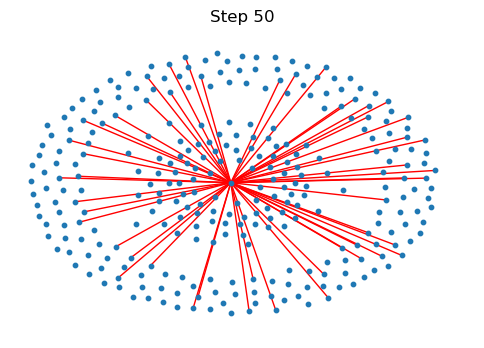

In [17]:
# ⚙️ RUNNING MST + ANIMATION ON A SAMPLE DATASET
dataset = "rec-amz-books.csv"
G = load_edge_list(dataset)
G = sample_connected_subgraph(G, 300)  # Use smaller graph for animation

mst_edges, steps = prim_mst_with_steps(G)
total_cost = sum(w for _, _, w in mst_edges)
print(f"📊 Prim MST Cost: {total_cost:.2f}")

animate_mst_steps(G, steps, save_path="prim_animation.gif")


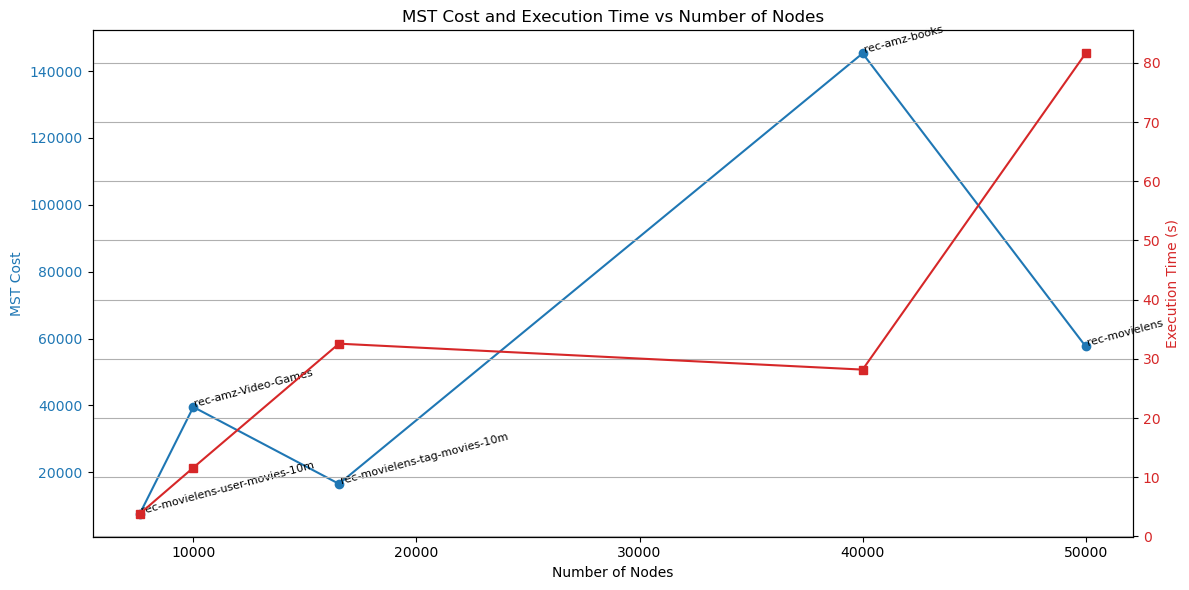

In [18]:
import matplotlib.pyplot as plt

# Data from your table
datasets = [
    "rec-movielens-user-movies-10m.csv",
    "rec-amz-Video-Games.csv",
    "rec-movielens-tag-movies-10m.csv",
    "rec-amz-books.csv",
    "rec-movielens.csv"
]

nodes = [7601, 10000, 16528, 40000, 50000]
edges = [55395, 14492, 71081, 143748, 8055535]
mst_cost = [7600.0, 39515.0, 16527.0, 145290.0, 57640.5]
exec_time = [3.85, 11.63, 32.57, 28.19, 81.61]  # Rounded for clarity

# Create figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot MST Cost
color = 'tab:blue'
ax1.set_xlabel("Number of Nodes")
ax1.set_ylabel("MST Cost", color=color)
ax1.plot(nodes, mst_cost, marker='o', color=color, label="MST Cost")
ax1.tick_params(axis='y', labelcolor=color)
for i, txt in enumerate(datasets):
    ax1.annotate(txt.split('.')[0], (nodes[i], mst_cost[i]), fontsize=8, rotation=15)

# Create second axis for Execution Time
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Execution Time (s)", color=color)
ax2.plot(nodes, exec_time, marker='s', color=color, label="Execution Time (s)")
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title("MST Cost and Execution Time vs Number of Nodes")
fig.tight_layout()
plt.grid(True)
plt.show()
